# disease

In [1]:
import logging
import typing as t
from functools import lru_cache
from logging import log

import networkx as nx
import owlready2
from scipy import sparse as sp

import numpy as np
import torch
import pandas as pd
import pandas_gbq
from google.cloud import bigquery

In [2]:
# Query template format
query_format = """
    select {column_name}, count(*) as num_cells 
    from `cas_2024_05_16_dataset.human_cellariumgpt_extract__extract_cell_info`
    group by {column_name}
    order by num_cells desc
"""

In [3]:
def get_ancestors_csr_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> sp.csr_matrix:
    """Returns a sparse matrix representation of ancestors.

    .. note:
        The matrix element (i, j) = 1 iff j is an ancetor of i.
    """
    n_nodes = len(graph.nodes)

    row = []
    col = []
    data = []

    for name, self_idx in names_to_idx_map.items():
        row.append(self_idx)
        col.append(self_idx)
        data.append(1)
        for ancestor_name in nx.ancestors(graph, name):
            ancestor_idx = names_to_idx_map[ancestor_name]
            row.append(self_idx)
            col.append(ancestor_idx)
            data.append(1)

    ancestors_csr_matrix = sp.csr_matrix((data, (row, col)), shape=(n_nodes, n_nodes))
    return ancestors_csr_matrix

In [4]:
def get_shortest_distances_matrix(graph, names_to_idx_map: t.Dict[str, int]) -> np.ndarray:
    """Returns a sparse matrix representation of shortest distances.

    .. note:
        The matrix element (i, j) = d iff d is the shortest distance between i and j.
    """
    n_nodes = len(graph.nodes)

    distance_matrix = np.full((n_nodes, n_nodes), np.inf)

    for target, value in dict(nx.all_pairs_shortest_path_length(graph)).items():
        for source, distance in value.items():
            source_idx = names_to_idx_map[source]
            target_idx = names_to_idx_map[target]
            distance_matrix[source_idx, target_idx] = distance
            distance_matrix[target_idx, source_idx] = distance

    return distance_matrix

## extract

In [5]:
query_name = "disease_ontology_term_id"
names_counts = pandas_gbq.read_gbq(
    query_format.format(column_name=query_name),
    project_id="dsp-cell-annotation-service",
)
names_counts

/home/yordabay/anaconda3/envs/ontology/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,disease_ontology_term_id,num_cells
0,PATO:0000461,25905102
1,MONDO:0100096,4109684
2,MONDO:0001627,1135641
3,MONDO:0018177,1001237
4,MONDO:0007915,708987
...,...,...
93,MONDO:0012419,1614
94,MONDO:0005348,1227
95,MONDO:0004994,1027
96,MONDO:0019562,1018


In [6]:
query_label = "disease"
labels_counts = pandas_gbq.read_gbq(
    query_format.format(column_name=query_label),
    project_id="dsp-cell-annotation-service",
)
labels_counts

/home/yordabay/anaconda3/envs/ontology/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2379: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,disease,num_cells
0,normal,25905102
1,COVID-19,4109684
2,dementia,1135641
3,glioblastoma,1001237
4,systemic lupus erythematosus,708987
...,...,...
93,age related macular degeneration 7,1614
94,keloid,1227
95,cardiomyopathy,1027
96,localized scleroderma,1018


How many different ontologies are used for `disease`?

In [7]:
set([value[0] for value in names_counts[query_name].str.split(":")])

{'MONDO', 'PATO'}

## ontology

In [15]:
# Used in CZ CELLxGENE schema v5:
# https://github.com/chanzuckerberg/single-cell-curation/blob/main/schema/5.0.0/schema.md
OWL_PATH = "https://github.com/monarch-initiative/mondo/releases/download/v2024-01-03/mondo.owl"

# only keep nodes with the following prefix when parsing CL ontology
PREFIX = "MONDO_"

# # the 'life cycle stage' node
# LIFE_CYCLE_STAGE_NODE = "HsapDv_0000000"

# # the 'life cycle' node
# LIFE_CYCLE_NODE = "HsapDv_0000001"

# relationships we need
PARTOF_RELATIONSHIP = "BFO_0000050"  # part_of

In [9]:
ontology = owlready2.get_ontology(OWL_PATH).load()

In [10]:
all_classes = list(ontology.classes())

In [11]:
# only keep CL classes with a singleton label
classes = list(
    _class for _class in all_classes if _class.name.startswith(PREFIX) and len(_class.label) == 1
)

names = [_class.name.replace("_", ":") for _class in classes]
labels = [str(_class.label[0]) for _class in classes]
assert len(set(names)) == len(classes)
# assert len(set(labels)) == len(classes)

In [12]:
# these are the labels that are not unique
non_unique_labels = []
for i in range(len(labels) - 1):
    if labels[i] in labels[i + 1 :]:
        non_unique_labels.append(labels[i])
non_unique_labels

['obsolete coronary heart disease',
 'obsolete deafness, autosomal recessive',
 'obsolete Wilms tumor',
 'obsolete emphysema',
 'obsolete gastric cancer',
 'obsolete microcephalic primordial dwarfism',
 'obsolete familial adenomatous polyposis',
 'obsolete Heimler syndrome',
 'obsolete epilepsy, familial focal, with variable foci',
 'obsolete Frontometaphyseal dysplasia',
 'obsolete JMP syndrome',
 'obsolete Walker-Warburg syndrome',
 'obsolete marginal zone B-cell lymphoma',
 'obsolete splenic marginal zone lymphoma',
 'obsolete small cell neuroendocrine carcinoma',
 'obsolete primary bone dysplasia with disorganized development of skeletal components',
 'obsolete nut midline carcinoma',
 'obsolete craniodiaphyseal dysplasia',
 'obsolete herpes simplex virus keratitis',
 'obsolete meningococcal meningitis',
 'obsolete chronic neutrophilic leukemia',
 'obsolete Friedreich ataxia',
 'obsolete ovarian cancer',
 'obsolete thymoma type AB',
 'obsolete thymic carcinoma',
 'obsolete cranioph

In [32]:
extract_names_to_labels_map = dict(zip(names_counts[query_name], labels_counts[query_label]))

In [13]:
classes_set = set(classes)
names_to_labels_map = {name: label for name, label in zip(names, labels)}
names_to_idx_map = {name: idx + 1 for idx, name in enumerate(names)}
names_to_idx_map["PATO:0000461"] = 0  # Add the normal cell type
# labels_to_names_map = {label: name for name, label in zip(names, labels)}
# labels_to_idx_map = {label: idx for idx, label in enumerate(labels)}
idx_to_names_map = {idx + 1: name for idx, name in enumerate(names)}
idx_to_names_map[0] = "PATO:0000461"  # Add the normal cell type
idx_to_labels_map = {idx + 1: label for idx, label in enumerate(labels)}
idx_to_labels_map[0] = "normal"

Are all `disease`s covered by the ontology tree?

In [14]:
set(names_counts[query_name]) - set(names)

{'PATO:0000461'}

In [16]:
# build a networkx graph from CL
graph = nx.DiGraph(name="CL graph")

graph.add_node("PATO:0000461")  # Add the normal cell type
for _class in classes:
    graph.add_node(_class.name.replace("_", ":"))

for self_class in classes:
    # parents
    for parent_class in ontology.get_parents_of(self_class):
        if parent_class not in classes_set:
            continue
        graph.add_edge(parent_class.name.replace("_", ":"), self_class.name.replace("_", ":"))
    # children
    for child_class in ontology.get_children_of(self_class):
        if child_class not in classes_set:
            continue
        graph.add_edge(self_class.name.replace("_", ":"), child_class.name.replace("_", ":"))
    # part of
    for prop in self_class.get_class_properties():
        if PARTOF_RELATIONSHIP in prop.name:
            for related_term in prop[self_class]:
                if related_term.name.startswith(PREFIX):
                    graph.add_edge(related_term.name.replace("_", ":"), self_class.name.replace("_", ":"))
    # deprecated terms (WHY???!!)
    if "deprecated" in [prop.name for prop in self_class.get_class_properties()]:
        for prop in self_class.get_class_properties():
            if "consider" in prop.name:
                for substitute in prop[self_class]:
                    substitute = str(substitute)
                    if substitute.startswith(PREFIX):
                        graph.add_edge(substitute, self_class.name.replace("_", ":"))

In [17]:
ancestors_matrix = get_ancestors_csr_matrix(graph, names_to_idx_map).toarray()
ancestors_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [20]:
shortest_distances_matrix = get_shortest_distances_matrix(graph, names_to_idx_map)
shortest_distances_matrix = np.where(ancestors_matrix, shortest_distances_matrix, np.inf)
shortest_distances_matrix

array([[ 0., inf, inf, ..., inf, inf, inf],
       [inf,  0., inf, ..., inf, inf, inf],
       [inf, inf,  0., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ...,  0., inf, inf],
       [inf, inf, inf, ..., inf,  0., inf],
       [inf, inf, inf, ..., inf, inf,  0.]])

Only leave nodes that exist in the data and their ancestors.

In [21]:
extract_names_set = set(names_counts[query_name])
extract_idx = [idx for name, idx in names_to_idx_map.items() if name in extract_names_set]
assert len(extract_idx) == len(extract_names_set)
len(extract_idx)

98

In [22]:
new_extract_idx = ancestors_matrix[extract_idx].any(axis=0).nonzero()[0].tolist()
len(new_extract_idx)

350

In [23]:
new_names = [idx_to_names_map[idx] for idx in new_extract_idx]
new_labels = [idx_to_labels_map[idx] for idx in new_extract_idx]

In [24]:
new_shortest_distances_matrix = shortest_distances_matrix[new_extract_idx][:, new_extract_idx]
# new_longest_distances_matrix = longest_distances_matrix[new_extract_idx][:, new_extract_idx]
new_ancestors_matrix = ancestors_matrix[new_extract_idx][:, new_extract_idx]

In [25]:
torch.save({
        "names": new_names,
        "labels": new_labels,
        "shortest_distances_matrix": torch.tensor(new_shortest_distances_matrix, dtype=torch.float32),
        # "longest_distances_matrix": torch.tensor(new_longest_distances_matrix, dtype=torch.float32),
        "ancestors_matrix": torch.tensor(new_ancestors_matrix, dtype=torch.int32),
    },
    "disease_ontology_data.pt"
)

In [63]:
len(set(new_labels) - set(labels_counts[query_label].values))

252

<Axes: xlabel='disease'>

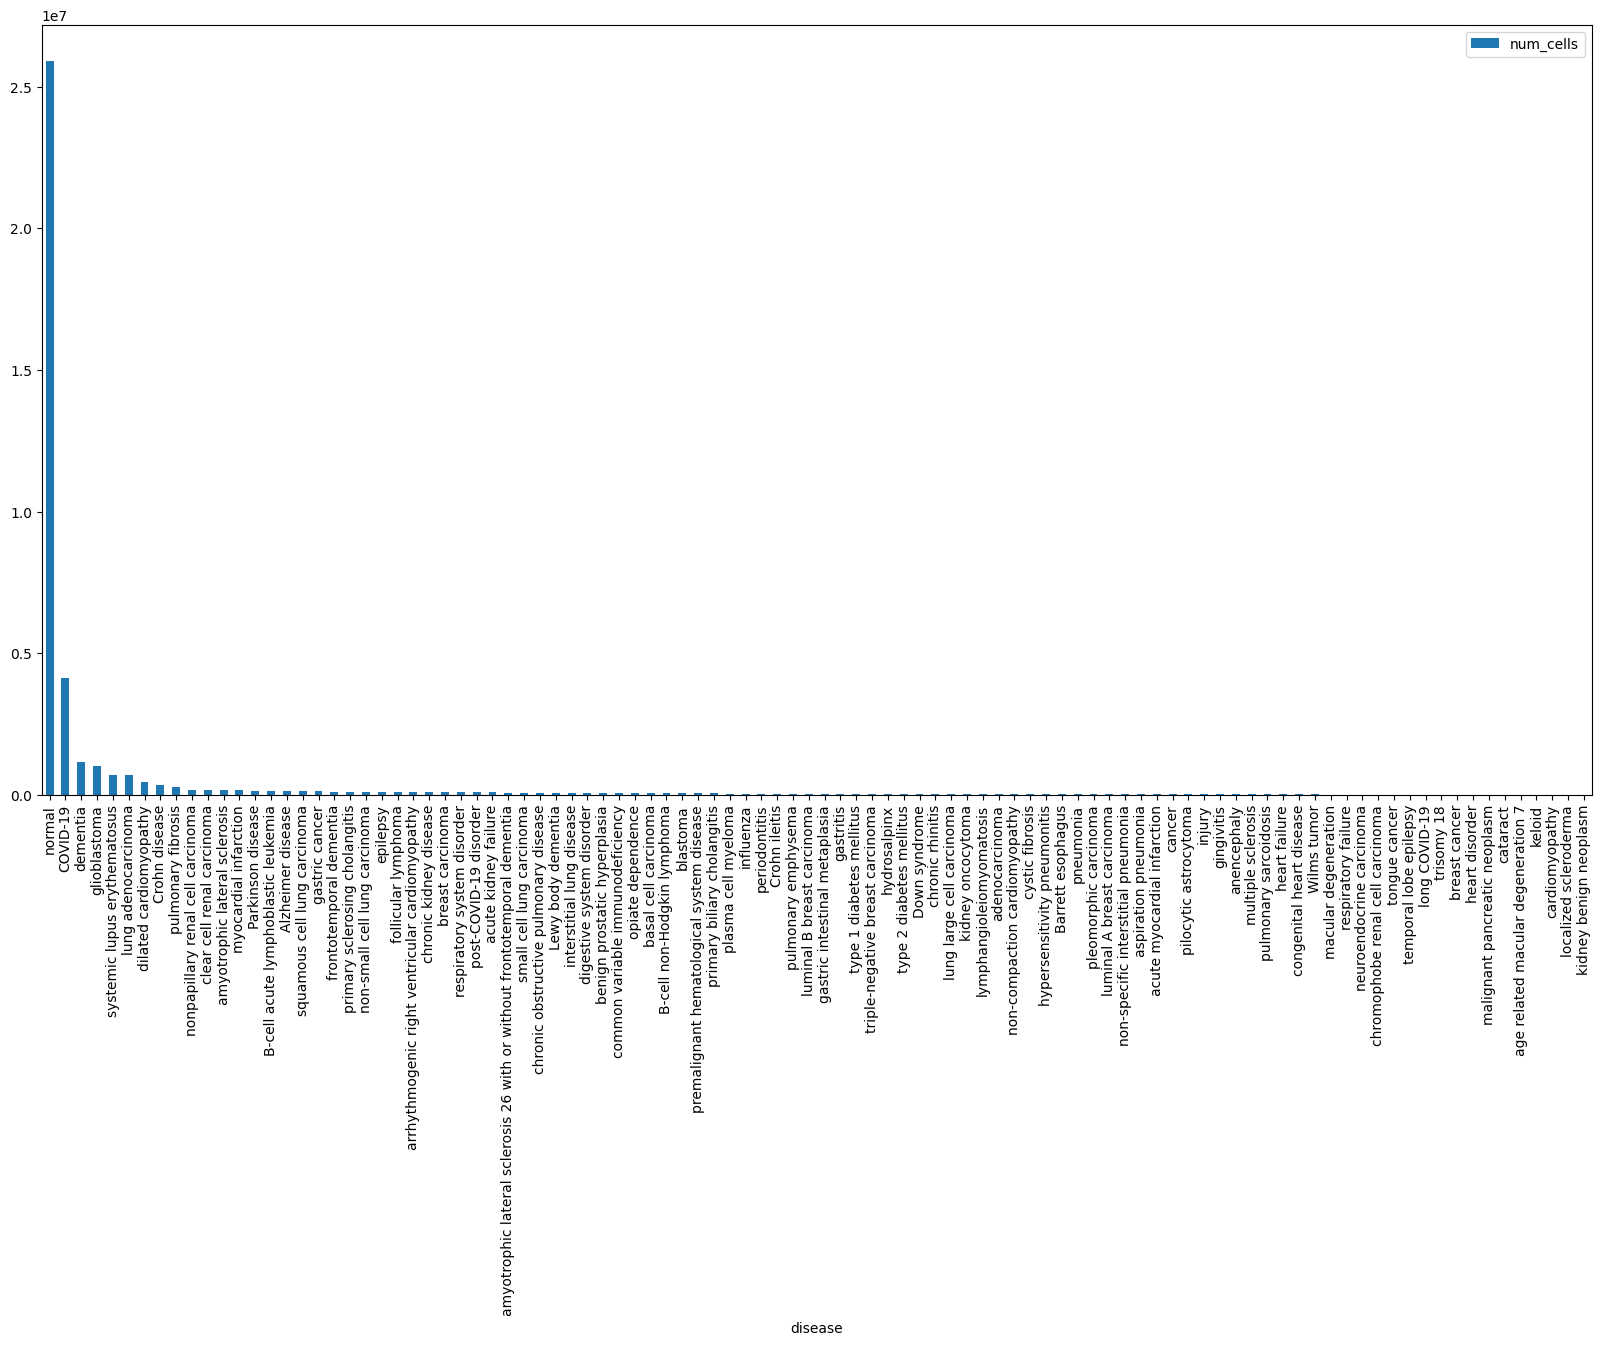

In [64]:
labels_counts.plot.bar(x=query_label, y="num_cells", figsize=(20, 10))